# Finetune VGG16


With 1920x1080 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_1080silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
from data_preprocessing.AveragePoolResize import AveragePoolResize

learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    AveragePoolResize((224, 224)),  # Resize to 224x224 via average pooling
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_9172\3223105130.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.38it/s, Loss=2.335660696029663, Elapsed=65.4386s, ETA=0.0000s]   


Epoch 1 completed in 320.7554s
Train Loss: 1.4357455269449708 - Train Accuracy: 39.336514325772825
Validation Loss: 1.290458477338155 - Validation Accuracy: 41.916420430561416

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=2.190685510635376, Elapsed=65.7462s, ETA=0.0000s]   


Epoch 2 completed in 325.4987s
Train Loss: 1.3444855178711732 - Train Accuracy: 42.20393025937903
Validation Loss: 1.2524749755859375 - Validation Accuracy: 45.78936260025327

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.38it/s, Loss=2.37788462638855, Elapsed=65.4501s, ETA=0.0000s]    


Epoch 3 completed in 329.3565s
Train Loss: 1.3294367859129272 - Train Accuracy: 42.814499898238395
Validation Loss: 1.224755711555481 - Validation Accuracy: 46.475306036302236

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.38it/s, Loss=2.331027030944824, Elapsed=65.4912s, ETA=0.0000s]   


Epoch 4 completed in 325.0622s
Train Loss: 1.3151809786785544 - Train Accuracy: 43.06777322991339
Validation Loss: 1.2135725990931192 - Validation Accuracy: 46.00042211903757

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:55<00:00,  1.36it/s, Loss=2.4769935607910156, Elapsed=66.0359s, ETA=0.0000s]  


Epoch 5 completed in 326.7330s
Train Loss: 1.3182508702567548 - Train Accuracy: 43.44316048936026
Validation Loss: 1.2363879124323527 - Validation Accuracy: 45.58885605740819

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:54<00:00,  1.37it/s, Loss=2.3754663467407227, Elapsed=65.7431s, ETA=0.0000s]  


Epoch 6 completed in 325.6246s
Train Loss: 1.3085752024471415 - Train Accuracy: 43.85925239139775
Validation Loss: 1.2080007640520731 - Validation Accuracy: 47.33009708737864

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.395742416381836, Elapsed=62.5105s, ETA=0.0000s]   


Epoch 7 completed in 314.8925s
Train Loss: 1.3096771092084103 - Train Accuracy: 43.59014947649307
Validation Loss: 1.2043218874931336 - Validation Accuracy: 46.20092866188265

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.627257823944092, Elapsed=62.3232s, ETA=0.0000s]   


Epoch 8 completed in 308.3755s
Train Loss: 1.3026496924761404 - Train Accuracy: 44.00624137853056
Validation Loss: 1.2152974478403726 - Validation Accuracy: 47.361756015196285

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.347346782684326, Elapsed=62.4732s, ETA=0.0000s]   


Epoch 9 completed in 307.5989s
Train Loss: 1.3093182313648952 - Train Accuracy: 43.67834286877276
Validation Loss: 1.2068493111928305 - Validation Accuracy: 46.0953989024905

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.485833168029785, Elapsed=62.2171s, ETA=0.0000s]   


Epoch 10 completed in 308.0393s
Train Loss: 1.306319317721218 - Train Accuracy: 43.87055923656181
Validation Loss: 1.2114455620447795 - Validation Accuracy: 48.70198395947657

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.722748279571533, Elapsed=62.3812s, ETA=0.0000s]   


Epoch 11 completed in 307.5248s
Train Loss: 1.3107399251419685 - Train Accuracy: 43.85699102236494
Validation Loss: 1.2371006027857463 - Validation Accuracy: 47.667792317433516

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.5217771530151367, Elapsed=62.2710s, ETA=0.0000s]  


Epoch 12 completed in 307.5185s
Train Loss: 1.3059193450591469 - Train Accuracy: 44.05146875918681
Validation Loss: 1.2099483323097229 - Validation Accuracy: 45.884339383706205

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s, Loss=2.5085461139678955, Elapsed=62.7387s, ETA=0.0000s]  


Epoch 13 completed in 307.9449s
Train Loss: 1.3006096713115713 - Train Accuracy: 44.04694602112119
Validation Loss: 1.1953418842951458 - Validation Accuracy: 46.78134233853947

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:52<00:00,  1.43it/s, Loss=2.297675132751465, Elapsed=63.2134s, ETA=0.0000s]   


Epoch 14 completed in 309.5931s
Train Loss: 1.3104888290339123 - Train Accuracy: 43.705479297166505
Validation Loss: 1.216187756061554 - Validation Accuracy: 46.25369354157873

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.313972234725952, Elapsed=62.4126s, ETA=0.0000s]   


Epoch 15 completed in 307.4366s
Train Loss: 1.3062402326936666 - Train Accuracy: 44.13513941340088
Validation Loss: 1.182250266869863 - Validation Accuracy: 47.39341494301393

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.4609689712524414, Elapsed=62.2283s, ETA=0.0000s]  


Epoch 16 completed in 307.4620s
Train Loss: 1.3059377005334534 - Train Accuracy: 43.99041179530088
Validation Loss: 1.1905477913220723 - Validation Accuracy: 49.029126213592235

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.31626296043396, Elapsed=62.3211s, ETA=0.0000s]    


Epoch 17 completed in 307.4667s
Train Loss: 1.300716951920118 - Train Accuracy: 44.30474209086181
Validation Loss: 1.1990215746561685 - Validation Accuracy: 45.641620937104264

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.4336836338043213, Elapsed=62.4495s, ETA=0.0000s]  


Epoch 18 completed in 308.0886s
Train Loss: 1.297537479441979 - Train Accuracy: 44.307003459894624
Validation Loss: 1.2218250528971355 - Validation Accuracy: 47.5833685099198

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s, Loss=2.4681947231292725, Elapsed=62.2533s, ETA=0.0000s]  


Epoch 19 completed in 307.8560s
Train Loss: 1.3130813967974888 - Train Accuracy: 43.76201352298681
Validation Loss: 1.203546211719513 - Validation Accuracy: 47.720557197129594

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s, Loss=2.3954176902770996, Elapsed=62.7253s, ETA=0.0000s]  


Epoch 20 completed in 307.6513s
Train Loss: 1.2969443083153984 - Train Accuracy: 44.307003459894624
Validation Loss: 1.1836059125264486 - Validation Accuracy: 46.760236386661035



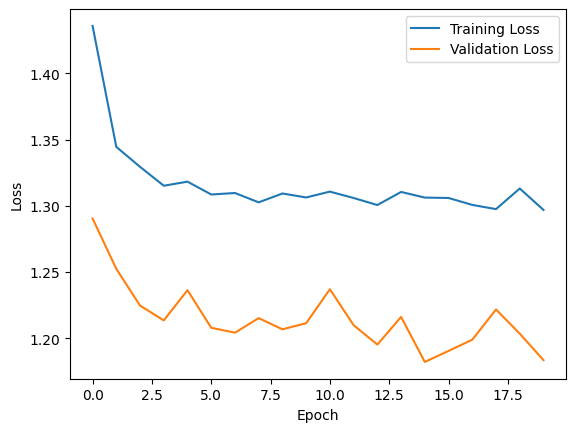

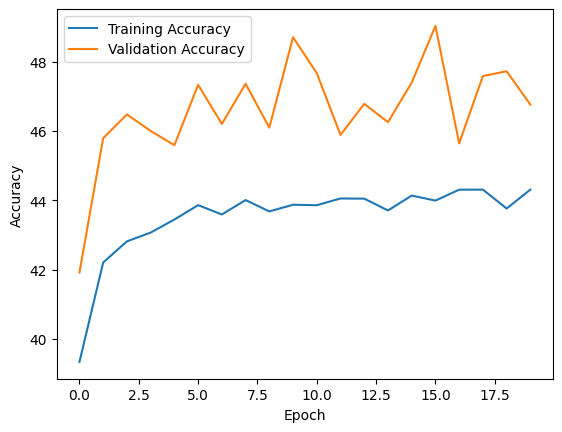

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_9172\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [01:03<00:00,  1.18it/s]

Test Accuracy: 0.4871
Test Precision: 0.5419
Test Recall: 0.4871
Test F1-score: 0.4688

              precision    recall  f1-score   support

       Anger       0.41      0.61      0.49       916
       Bored       0.62      0.80      0.70      1098
     Disgust       0.36      0.53      0.43       291
        Fear       0.22      0.67      0.33       308
       Happy       0.70      0.20      0.31      1914
     Neutral       0.55      0.32      0.40      2226
    Question       0.53      0.75      0.62      1139
         Sad       0.50      0.50      0.50       857
    Surprise       0.44      0.62      0.52       728

    accuracy                           0.49      9477
   macro avg       0.48      0.55      0.48      9477
weighted avg       0.54      0.49      0.47      9477



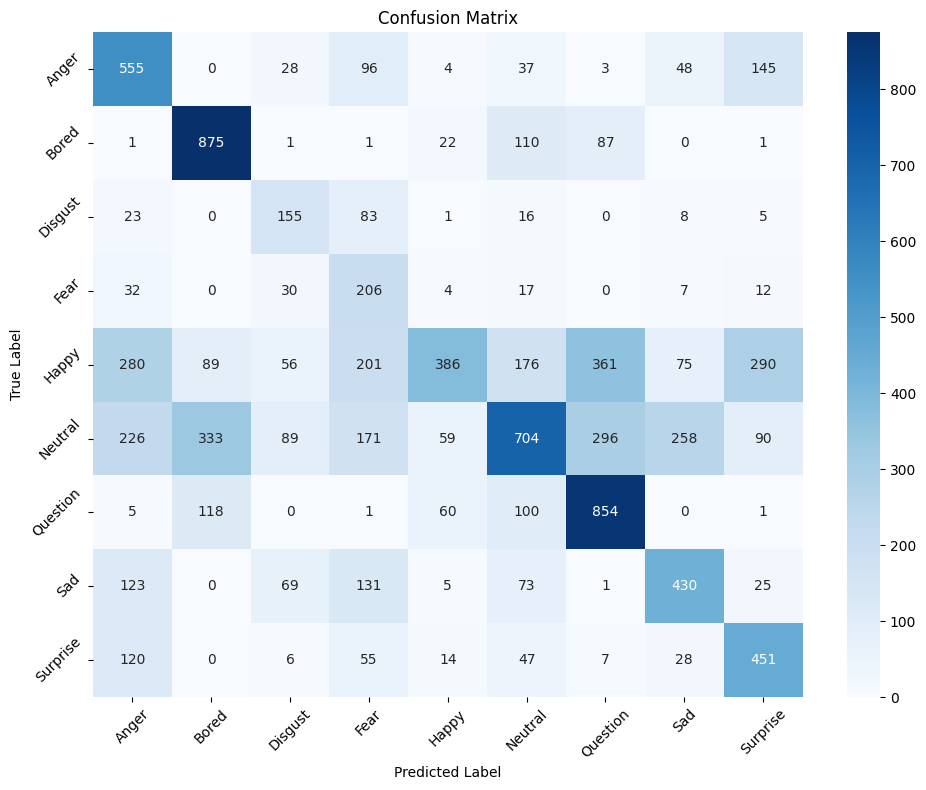

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)